In [1]:

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt


from config import ModelConfig, TrainingConfig, HardwareConfig, DataConfig

import xarray as xr
import torch

import pandas as pd

import os
import glob
import re
from tqdm import tqdm
import plotly.io as pio

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


import seaborn as sns

from VAE_GMM import VAE
from dataset import CustomDataset, DataModule
from sklearn.mixture import GaussianMixture
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib as mpl




mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 10,      # Schriftgröße Achsenbeschriftung
    "axes.titlesize": 10,      # Schriftgröße Titel
    "axes.linewidth": 0.5,     # Achsenlinienbreite
    "lines.linewidth": 0.5,    # Linienbreite
    "font.size": 10,           # Grundschriftgröße
    "legend.fontsize": 10,     # Legende
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    #"figure.figsize": (5.7, 3.5),  # z.B. 145mm x 90mm in inch
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "pgf.preamble": "\n".join([
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english]{babel}"
    ]),
})


text_width_mm = 145
inches_per_mm = 1/25.4
fig_width_in = text_width_mm * inches_per_mm
fig_height_in = fig_width_in * 0.6

In [17]:
def gather_data(loader):
    """Sammelt alle Batches und gibt ein numpy-Array (N,1,lat,lon) zurück."""
    arrs = []
    with torch.no_grad():
        for xb, _ in tqdm(loader, desc="Loading data"):
            arrs.append(xb)
    data = torch.cat(arrs, dim=0).cpu().numpy()
    return data

def compute_pca_kmeans_baseline(
    train_data, val_data,
    n_components=10, n_clusters=5, seed=42,
    k_smooth=10
):
    """
    PCA (fit auf Train), KMeans (fit auf Train, predict auf Val),
    Rekonstruktions-MSE und Cluster-Metriken + optional Smoothness.
    """
    flat_train = train_data[:,0].reshape(train_data.shape[0], -1)
    flat_val   = val_data [:,0].reshape(val_data.shape[0],  -1)

    # PCA auf train
    pca = PCA(n_components=n_components, whiten=False)
    scores_train = pca.fit_transform(flat_train)
    scores_val   = pca.transform(flat_val)

    # KMeans auf train
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=seed)
    kmeans.fit(scores_train)
    labels_val = kmeans.predict(scores_val)

    # Rekonstruktions-MSE auf Val
    recon_val = pca.inverse_transform(scores_val)
    recon_train = pca.inverse_transform(scores_train)
    loss_recon = float(np.mean((flat_train - recon_train)**2))

    # Cluster-Metriken auf Val
    sil = float(silhouette_score(scores_val, labels_val))
    cal = float(calinski_harabasz_score(scores_val, labels_val))
    db  = float(davies_bouldin_score(scores_val, labels_val))
    ps  = np.bincount(labels_val) / labels_val.size
    ent = float(-np.sum(ps * np.log(ps + 1e-10)))
    scores_std = (scores_val - scores_val.mean(axis=0)) / (scores_val.std(axis=0) + 1e-10)
    z_torch = torch.from_numpy(scores_std).float()
    smooth, density_var, gauss_sim = compute_smoothness(z_torch, k=k_smooth)

    baseline_raw = {
        "loss_recon":          loss_recon,
        "silhouette":          sil,
        "calinski_harabasz":   cal,
        "davies_bouldin":      db,
        "cluster_entropy":     ent,
        "smoothness":          smooth,
        "density_variation":   density_var,
        "gaussian_similarity": gauss_sim,
    }

    return baseline_raw, pca, scores_val


def compute_smoothness(z: torch.Tensor, k: int = 10):
    """
    Deine VAE-Smoothness-Funktion auch für PCA-Scores.
    Erwartet z bereits zero-centered und unit-std.
    Liefert smoothness, density_variation, gaussian_similarity.
    """
    distances = torch.cdist(z, z)
    knn, _ = torch.topk(distances, k, largest=False)
    density_variation = torch.std(knn[:,1:])
    z_std = torch.std(z, dim=0)
    gaussian_similarity = -torch.mean(torch.abs(z_std - 1.0))
    smoothness = -density_variation + gaussian_similarity
    return float(smoothness), float(density_variation), float(gaussian_similarity)

def load_vae_metrics_tensorboard(base_logs, experiments, metric_tags):
    """
    Lädt für jede (exp_name,version) den letzten Wert aller metric_tags aus TB.
    Gibt DataFrame mit Spalten exp_name, version und Metriken zurück.
    """
    from tb_utils import load_tensorboard_scalars
    records = []
    for exp_name, versions in experiments.items():
        for v in versions:
            logdir = os.path.join(base_logs, exp_name, f"version_{v}")
            row = {"exp_name": exp_name, "version": v}
            for m, tag in metric_tags.items():
                try:
                    _, vals, _ = load_tensorboard_scalars(logdir, tag)
                    row[m] = float(vals[-1])
                except Exception:
                    row[m] = np.nan
            records.append(row)
    return pd.DataFrame(records)


def compute_norm_bounds(
    df: pd.DataFrame,
    keys: list[str],
    fixed_min: dict[str,float] | None = None,
    fixed_max: dict[str,float] | None = None
) -> tuple[dict[str,float], dict[str,float]]:
    """
    Liefert für jede Metrik in `keys` ein (min,max)-Paar.
    - Wenn `fixed_min` und `fixed_max` gegeben sind, werden diese zurückgegeben.
    - Ansonsten werden sie aus df[keys] per df.min()/df.max() ermittelt.
    """
    if fixed_min is not None and fixed_max is not None:
        # vollständige Übernahme der festen Grenzen
        return fixed_min.copy(), fixed_max.copy()
    # dynamisch aus den Daten berechnen
    gmin = df[keys].min().to_dict()
    gmax = df[keys].max().to_dict()
    return gmin, gmax


def prepare_radar_df(
    df: pd.DataFrame,
    keys: list[str],
    invert_keys: list[str],
    top_n: int | None = None,
    baseline_raw: dict[str,float] | None = None,
    norm_source_df: pd.DataFrame | None = None,
    fixed_min: dict[str,float] | None = None,
    fixed_max: dict[str,float] | None = None,
    baseline_name: str = "PCA+KMeans"
) -> pd.DataFrame:
    df_work = df.copy()

    # 1) Baseline anhängen
    if baseline_raw is not None:
        row = {"exp_name": baseline_name, "version": np.nan}
        row.update(baseline_raw)
        df_work = pd.concat([df_work, pd.DataFrame([row])], ignore_index=True)

    # 2) Top-N Auswahl
    if top_n is not None:
        mask = df_work["exp_name"] != baseline_name
        top_idx = df_work[mask].nlargest(top_n, "silhouette").index
        sel = top_idx.tolist()
        if baseline_raw is not None:
            base_idx = df_work[df_work["exp_name"]==baseline_name].index
            sel += base_idx.tolist()
        df_work = df_work.loc[sel].reset_index(drop=True)

    # 3) Normierungsgrenzen ermitteln
    if fixed_min is not None and fixed_max is not None:
        gmin, gmax = fixed_min.copy(), fixed_max.copy()
    else:
        source = norm_source_df if norm_source_df is not None else df_work
        gmin = source[keys].min().to_dict()
        gmax = source[keys].max().to_dict()

    # 4) Normieren
    for k in keys:
        mn, mx = gmin[k], gmax[k]
        df_work[f"{k}_norm"] = df_work[k].apply(
            lambda v: 1.0 if np.isclose(mx,mn)
                      else (1-(v-mn)/(mx-mn) if k in invert_keys
                            else (v-mn)/(mx-mn))
        )
    return df_work



def plot_radar(
    df_plot,
    keys,
    metric_display=None,
    title=None
):
    """
    Zeichnet ein Radar-Plot über die in `keys` angegebenen Metriken,
    aber nur für jene, die in metric_display vorkommen UND deren
    normierte Spalte im DataFrame existiert.
    Die Baseline (exp_name=='PCA+KMeans') wird immer schwarz und gestrichelt gezeichnet.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection
    from matplotlib.lines import Line2D
    from matplotlib.ticker import PercentFormatter

    metric_display = metric_display or {}

    # 1) Filter Keys: nur solche mit Label *und* mit vorhandener Norm-Spalte
    keys_plot = [
        k for k in keys
        if k in metric_display and f"{k}_norm" in df_plot.columns
    ]
    if not keys_plot:
        raise ValueError("Keine gültigen Metriken zum Plotten übrig!")

    # 2) Achsen-Beschriftungen und normierte Spalten
    metric_labels = [metric_display[k] for k in keys_plot]
    norm_cols     = [f"{k}_norm"   for k in keys_plot]

    # 3) Winkel berechnen
    angles = np.linspace(0, 2*np.pi, len(keys_plot), endpoint=False).tolist()
    angles += angles[:1]

    # 4) Polygone zusammenstellen
    verts = []
    for _, row in df_plot[norm_cols].iterrows():
        vals = row.values.tolist() + [row.values.tolist()[0]]
        verts.append(list(zip(angles, vals)))

    # 5) Plot-Setup
    fig, ax = plt.subplots(figsize=(fig_width_in,fig_width_in*0.9), subplot_kw=dict(polar=True))
    ax.set_ylim(0,1)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels(['', '50%', '100%'])
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    ax.set_xticks(angles[:-1])
    label_radii = []
    for angle in angles[:-1]:
        deg = np.degrees(angle) % 360
        if np.isclose(deg, 0, atol=1) or np.isclose(deg, 180, atol=1):
            label_radii.append(1.4)
        elif np.isclose(deg, 90, atol=1) or np.isclose(deg, 270, atol=1):
            label_radii.append(1.2)
        else:
            label_radii.append(1.2)
    for label, angle, radius in zip(metric_labels, angles[:-1], label_radii):
        ax.text(angle, radius, label, fontweight='bold', ha='center', va='center')



    ax.grid(color='black', linestyle='--', linewidth=0.7)

    # 6) Flächen (optional, können für Baseline transparent gemacht werden)
    n = len(verts)
    cmap = plt.get_cmap('Set2', n)
    facecols = []
    for i in range(n):
        # Optional: Baseline-Fläche weiß und transparent
        exp_name = str(df_plot['exp_name'].iloc[i]) if 'exp_name' in df_plot.columns else ""
        if exp_name == "PCA+KMeans":
            facecols.append((1,1,1,0))  # völlig transparent
        else:
            facecols.append(cmap(i)[0:3] + (0.2,))
    poly = PolyCollection(verts, facecolors=facecols,
                          edgecolors=['gray']*n, linewidth=1)
    ax.add_collection(poly)

    # 7) Linien (hier ist das Entscheidende!)
    labels = df_plot['exp_name'].tolist() if 'exp_name' in df_plot.columns else list(df_plot.index)
    for i, v in enumerate(verts):
        xs, ys = zip(*v)
        exp_name = labels[i] if isinstance(labels[i], str) else str(labels[i])
        if exp_name == "PCA+KMeans":
            ax.plot(xs, ys, color='black', linestyle='--', linewidth=2.5, zorder=4)
        else:
            ax.plot(xs, ys, color=cmap(i), linewidth=2, zorder=3)
    ax.set_xticklabels([])

    # 8) Legende
    handles = []
    for i, label in enumerate(labels):
        if label == "PCA+KMeans":
            handles.append(Line2D([0],[0], color='black', linestyle='--', lw=2.5))
        else:
            handles.append(Line2D([0],[0], color=cmap(i), lw=2))
    ax.legend(handles, labels, loc = 'center left', bbox_to_anchor=(1.2, 1.0), frameon=False)

    if title:
        ax.set_title(title, pad=20)
    plt.tight_layout()
    plt.subplots_adjust(right = 0.8)
    plt.show()
    

def evaluate_vae_on_validation(
    vae_model,
    val_loader,
    device="cpu",
    verbose=False
):
    """
    Berechnet VAE-Clustering- und Rekonstruktionsmetriken auf dem kompletten Validation-Set.
    Gibt ein dict zurück mit allen Werten.
    """

    vae_model.eval()
    all_x = []
    all_mu = []
    all_labels = []
    all_x_recon = []

    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            x_recon, mu, log_var, z = vae_model(xb)  # Passen: je nach Modell-Output
            # Clusterzuweisungen, z. B. über GMM:
            if hasattr(vae_model, "gaussian_mixture_log_prob"):
                _, gamma = vae_model.gaussian_mixture_log_prob(z)
                labels = torch.argmax(gamma, dim=1)
            else:
                # Fallback: evt. alternative Clusterlabels
                labels = torch.zeros(len(xb), dtype=torch.long)
            all_x.append(xb.cpu())
            all_x_recon.append(x_recon.cpu())
            all_mu.append(mu.cpu())
            all_labels.append(labels.cpu())

    # Zu einem großen Array zusammenfassen
    X_val      = torch.cat(all_x, dim=0).numpy()
    X_reconval = torch.cat(all_x_recon, dim=0).numpy()
    mu_val     = torch.cat(all_mu, dim=0).numpy()
    labels_val = torch.cat(all_labels, dim=0).numpy()

    # 1. Reconstruction Loss (MSE)
    loss_recon = float(np.mean((X_val - X_reconval)**2))

    # 2. Clustering-Metriken im Latent Space (mu)
    try:
        silhouette = float(silhouette_score(mu_val, labels_val))
    except Exception:
        silhouette = float('nan')
    try:
        calinski   = float(calinski_harabasz_score(mu_val, labels_val))
    except Exception:
        calinski = float('nan')
    try:
        db_index   = float(davies_bouldin_score(mu_val, labels_val))
    except Exception:
        db_index = float('nan')
    # Cluster-Entropie
    ps = np.bincount(labels_val) / labels_val.size
    cluster_entropy = float(-np.sum(ps * np.log(ps + 1e-10)))

    # 3. Smoothness-Metrik (optional, falls Funktion übergeben)
    if compute_smoothness is not None:
        mu_std = (mu_val - mu_val.mean(axis=0)) / (mu_val.std(axis=0) + 1e-10)
        z_torch = torch.from_numpy(mu_std).float()
        smoothness, density_var, gauss_sim = compute_smoothness(z_torch)
    else:
        smoothness, density_var, gauss_sim = float('nan'), float('nan'), float('nan')

    # Alles als dict zurückgeben
    metrics = {
        "loss_recon": loss_recon,
        "silhouette": silhouette,
        "calinski_harabasz": calinski,
        "davies_bouldin": db_index,
        "cluster_entropy": cluster_entropy,
        "smoothness": smoothness,
        "density_variation": density_var,
        "gaussian_similarity": gauss_sim
    }

    if verbose:
        print("Validation Metrics:")
        for k,v in metrics.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    return metrics


def evaluate_all_vae_models(
    base_logs,
    experiment,
    versions,
    vae_class,
    val_loader,
    device,
    compute_smoothness=None,
    k_for_smoothness=10,
    verbose=False
):
    results = []
    for ver in versions:
        ckpt_path = os.path.join(
            base_logs, experiment, f"version_{ver}", "checkpoints", "last.ckpt"
        )
        if not os.path.isfile(ckpt_path):
            print(f"Checkpoint fehlt für Version {ver}: {ckpt_path}")
            continue

        # Modell laden (passe den Klassennamen ggf. an)
        model = vae_class.load_from_checkpoint(ckpt_path, map_location=device)
        model.to(device)
        model.eval()

        # Metriken berechnen
        metrics = evaluate_vae_on_validation(
            vae_model=model,
            val_loader=val_loader,
            device=device,
            verbose=verbose
        )
        metrics["version"] = ver
        results.append(metrics)
    return results


In [6]:
from VAE_GMM import VAE  # oder wie deine Klasse wirklich heißt

file_path  = "/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc"

base_logs  = "/work/aa0238/a271125/logs/StableVAE"
experiment = "Exp_400Epochs"
versions   = list(range(1, 10))

# DataModule und Validation-Loader
dm = DataModule(data_dir=file_path, batch_size=400, num_workers=8)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Top-Level Loop für alle Versionen
results = evaluate_all_vae_models(
    base_logs=base_logs,
    experiment=experiment,
    versions=versions,
    vae_class=VAE,
    val_loader=train_loader,
    device=device,
    verbose=False
)

df_vae = pd.DataFrame(results)


Anzahl std_value == 0: 362
std_value min/max: 0.0 17.128105


In [7]:
baseline_raw, pca, scores_val = compute_pca_kmeans_baseline(
    gather_data(train_loader),
    gather_data(val_loader)
)
baseline_raw["exp_name"] = "PCA+KMeans"
df_kmeans = pd.DataFrame([baseline_raw])

df_kmeans

Loading data: 100%|██████████| 11/11 [00:00<00:00, 16.08it/s]


,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,smoothness,density_variation,gaussian_similarity,exp_name
0,0.099981,0.095753,440.693188,2.170875,1.608609,-0.461468,0.461351,-0.000117,PCA+KMeans


In [8]:
# Sortiere nach Silhouette (absteigend), dann nach Rekonstruktions-Loss (aufsteigend)
df_vae_sorted = df_vae.sort_values(
    by=["silhouette", "loss_recon"],
    ascending=[False, True]
)
top3 = df_vae_sorted.head(3)

df_vae_sorted

,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,smoothness,density_variation,gaussian_similarity,version
4,0.213870,0.119569,2965.358185,1.602335,1.608924,-0.192308,0.192279,-0.00003,5
3,0.212660,0.118284,2867.386125,1.633074,1.609020,-0.271541,0.271511,-0.00003,4
2,0.214450,0.117763,2894.425199,1.676296,1.603849,-0.192511,0.192481,-0.00003,3
7,0.213463,0.116639,2860.162930,1.662956,1.609239,-0.223045,0.223015,-0.00003,8
0,0.208574,0.110840,2608.419974,1.768104,1.606807,-0.253743,0.253713,-0.00003,1
5,0.209225,0.108875,2518.044253,1.756498,1.609236,-0.245625,0.245595,-0.00003,6
1,0.206129,0.107596,2521.160280,1.833486,1.608815,-0.250806,0.250777,-0.00003,2
6,0.210366,0.105537,2476.188921,1.754488,1.606975,-0.263025,0.262995,-0.00003,7
8,0.209019,0.103782,2430.106521,1.757052,1.608189,-0.269463,0.269433,-0.00003,9


In [9]:
df_plot = pd.concat([top3, df_kmeans], ignore_index=True)


metrics = [
    "loss_recon",
    "silhouette",
    "calinski_harabasz",
    "davies_bouldin",
    "cluster_entropy",
    "smoothness",
#    "vae_density_variation"
]

metric_display = {
    "loss_recon": "Reconstruction",
    "silhouette": "Silhouette",
    "calinski_harabasz": "Calinski–Harabasz",
    "davies_bouldin": "Davies–Bouldin",
    "cluster_entropy": "Cluster Entropy",
    "smoothness": "Smoothness",
}

In [10]:
df_plot

,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,smoothness,density_variation,gaussian_similarity,version,exp_name
0,0.213870,0.119569,2965.358185,1.602335,1.608924,-0.192308,0.192279,-0.000030,5.0,NaN
1,0.212660,0.118284,2867.386125,1.633074,1.609020,-0.271541,0.271511,-0.000030,4.0,NaN
2,0.214450,0.117763,2894.425199,1.676296,1.603849,-0.192511,0.192481,-0.000030,3.0,NaN
3,0.099981,0.095753,440.693188,2.170875,1.608609,-0.461468,0.461351,-0.000117,NaN,PCA+KMeans


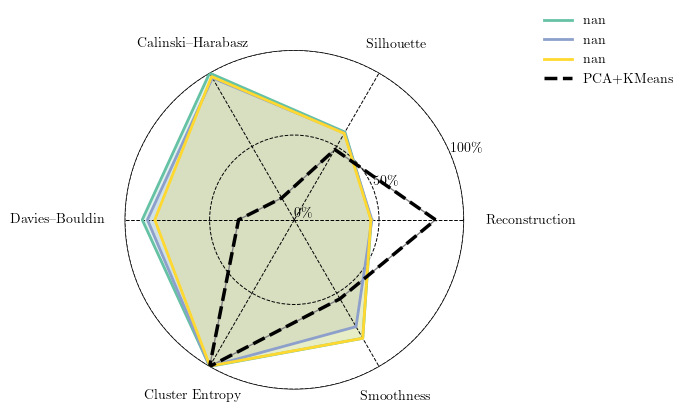

In [18]:
fixed_min = {
    "loss_recon":        0.35,
    "silhouette":        0.0,
    "calinski_harabasz": 0.0,
    "davies_bouldin":    2.5,
    "cluster_entropy":   0.0,
    "smoothness":       -1.0,  # falls deine Werte in diesem Bereich liegen
}

fixed_max = {
    "loss_recon":        0.05,  # Oder festen Wert
    "silhouette":        0.2,
    "calinski_harabasz": df_plot["calinski_harabasz"].max(),
    "davies_bouldin":    1.5,
    "cluster_entropy":   np.log(5),  # oder wie viele Cluster du hast
    "smoothness":        0.0,
}

invert_keys = [] #["loss_recon", "davies_bouldin"]


df_radar_fixed = prepare_radar_df(
    df_plot,
    keys=metrics,
    invert_keys=invert_keys,
    fixed_min=fixed_min,
    fixed_max=fixed_max
)
plot_radar(df_radar_fixed, keys=metrics, metric_display=metric_display)#, title="Top-3 VAE + PCA/KMeans (fixe Skala)")

In [12]:
df_radar_fixed

,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,smoothness,density_variation,gaussian_similarity,version,exp_name,loss_recon_norm,silhouette_norm,calinski_harabasz_norm,davies_bouldin_norm,cluster_entropy_norm,smoothness_norm
0,0.213870,0.119569,2965.358185,1.602335,1.608924,-0.192308,0.192279,-0.000030,5.0,NaN,0.453766,0.597844,1.000000,0.897665,0.999681,0.807692
1,0.212660,0.118284,2867.386125,1.633074,1.609020,-0.271541,0.271511,-0.000030,4.0,NaN,0.457799,0.591418,0.966961,0.866926,0.999740,0.728459
2,0.214450,0.117763,2894.425199,1.676296,1.603849,-0.192511,0.192481,-0.000030,3.0,NaN,0.451835,0.588817,0.976079,0.823704,0.996527,0.807489
3,0.099981,0.095753,440.693188,2.170875,1.608609,-0.461468,0.461351,-0.000117,NaN,PCA+KMeans,0.833396,0.478764,0.148614,0.329125,0.999485,0.538532


In [19]:
plot_radar(df_radar_norm, keys=metrics, metric_display=metric_display)


NameError: name 'df_radar_norm' is not defined

In [ ]:
df_plot